# Debugging dask workflows: Detrending part 1

Detrending - subtracting a trend, commonly a linear fit, from the data - along the time dimension is a common workflow in the climate sciences. 

Detrending with dask is a consistent source of headaches:
1. [Polyfit performance on large datasets - Suboptimal dask task graph](https://github.com/pydata/xarray/issues/5629)
1. [Unexpected chunking of 3d DataArray in polyfit()](https://github.com/pydata/xarray/issues/4554)
1. [Memory errors with detrending + rolling operations](https://github.com/pydata/xarray/discussions/6280)

## Challenges of detrending

The main challenge is that model output is usually chunked with small chunksizes in time, and big chunksizes in space.

We usually want to subtract a linear trend in time. Naively detrending along time using `xarray.apply_ufunc(numpy.polyfit, ..., dask="parallelized")` would then require rechunking the dataset. 

[`DataArray.polyfit`](https://xarray.pydata.org/en/latest/generated/xarray.DataArray.polyfit.html) is actually smart about this, and uses [`dask.array.linalg.lstsq`](https://docs.dask.org/en/stable/generated/dask.array.linalg.lstsq.html) for an out-of-core parallel fitting algorithm. 

However the limitation of `lstsq` is that it requires 2D arrays as input, but our model output is 3D or 4D (time, depth, lat, lon). `polyfit` uses [`DataArray.stack`](https://xarray.pydata.org/en/latest/generated/xarray.DataArray.stack.html) to reshape all arrays to 2D, does the fit, and reshapes back. Easy, no?

Turns out.. not easy. Reshaping in parallel can be really expensive! The [dask docs](https://docs.dask.org/en/stable/array-chunks.html#reshaping) illustrate this well. I wrote up a [solution](https://github.com/pydata/xarray/issues/5629#issuecomment-960133879) but this hasn't been implemented yet (potentially a future blogpost). It also turned out that this wasn't the issue that affected  [Memory errors with detrending + rolling operations](https://github.com/pydata/xarray/discussions/6280)

In this notebook, I try to explore this problem a little bit to find what other challenges affect detrending workflows.

Unfortunately it turns out the problem is a serious [regression](https://github.com/dask/dask/issues/6916) in dask, so we'll have to wait for a fix.

## Setup

In [1]:
import dask.array
import distributed
import numpy as np
import xarray as xr
from IPython.display import Image

In [2]:
client = distributed.Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53118,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:53134,Total threads: 2
Dashboard: http://127.0.0.1:53138/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:53124,


## Example detrending operation

I'll use the example dataset in [Memory errors with detrending + rolling operations](https://github.com/pydata/xarray/discussions/6280) 

In [3]:
nt = 8772 // 4
ny = 489
nx = 655
# chunks like the data is stored on disk
# small in time, big in space
# because the chunk sizes are -1 along lat, lon;
# reshaping this array to (time, latlon) prior to fitting is pretty cheap
chunks = (8, -1, -1)

da = xr.DataArray(
    dask.array.random.random((nt, ny, nx), chunks=chunks),
    dims=("ocean_time", "eta_rho", "xi_rho"),
)
da

<xarray.DataArray 'random_sample-62154c069399b3f4aff37e51dcc288d6' (ocean_time: 2193, eta_rho: 489, xi_rho: 655)>
dask.array<random_sample, shape=(2193, 489, 655), dtype=float64, chunksize=(8, 489, 655), chunktype=numpy.ndarray>
Dimensions without coordinates: ocean_time, eta_rho, xi_rho

In [4]:
# Function to detrend
# Source: https://gist.github.com/rabernat/1ea82bb067c3273a6166d1b1f77d490f
def detrend_dim(da, dim, deg=1):
    """detrend along a single dimension."""
    # calculate polynomial coefficients
    p = da.polyfit(dim=dim, deg=deg, skipna=False)
    # evaluate trend
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    # remove the trend
    return da - fit


detrended = detrend_dim(da, dim="ocean_time")
detrended

<xarray.DataArray (ocean_time: 2193, eta_rho: 489, xi_rho: 655)>
dask.array<sub, shape=(2193, 489, 655), dtype=float64, chunksize=(8, 489, 655), chunktype=numpy.ndarray>
Coordinates:
  * ocean_time  (ocean_time) int64 0 1 2 3 4 5 ... 2187 2188 2189 2190 2191 2192
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 482 483 484 485 486 487 488
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 648 649 650 651 652 653 654

In [ ]:
detrended.compute()

Calling compute doesn't work so well and that single `tensordot` task looks funny. We have many input chunks and many output chunks. It's not good if there's a single task that might be a bottleneck by accumulating many input chunks.

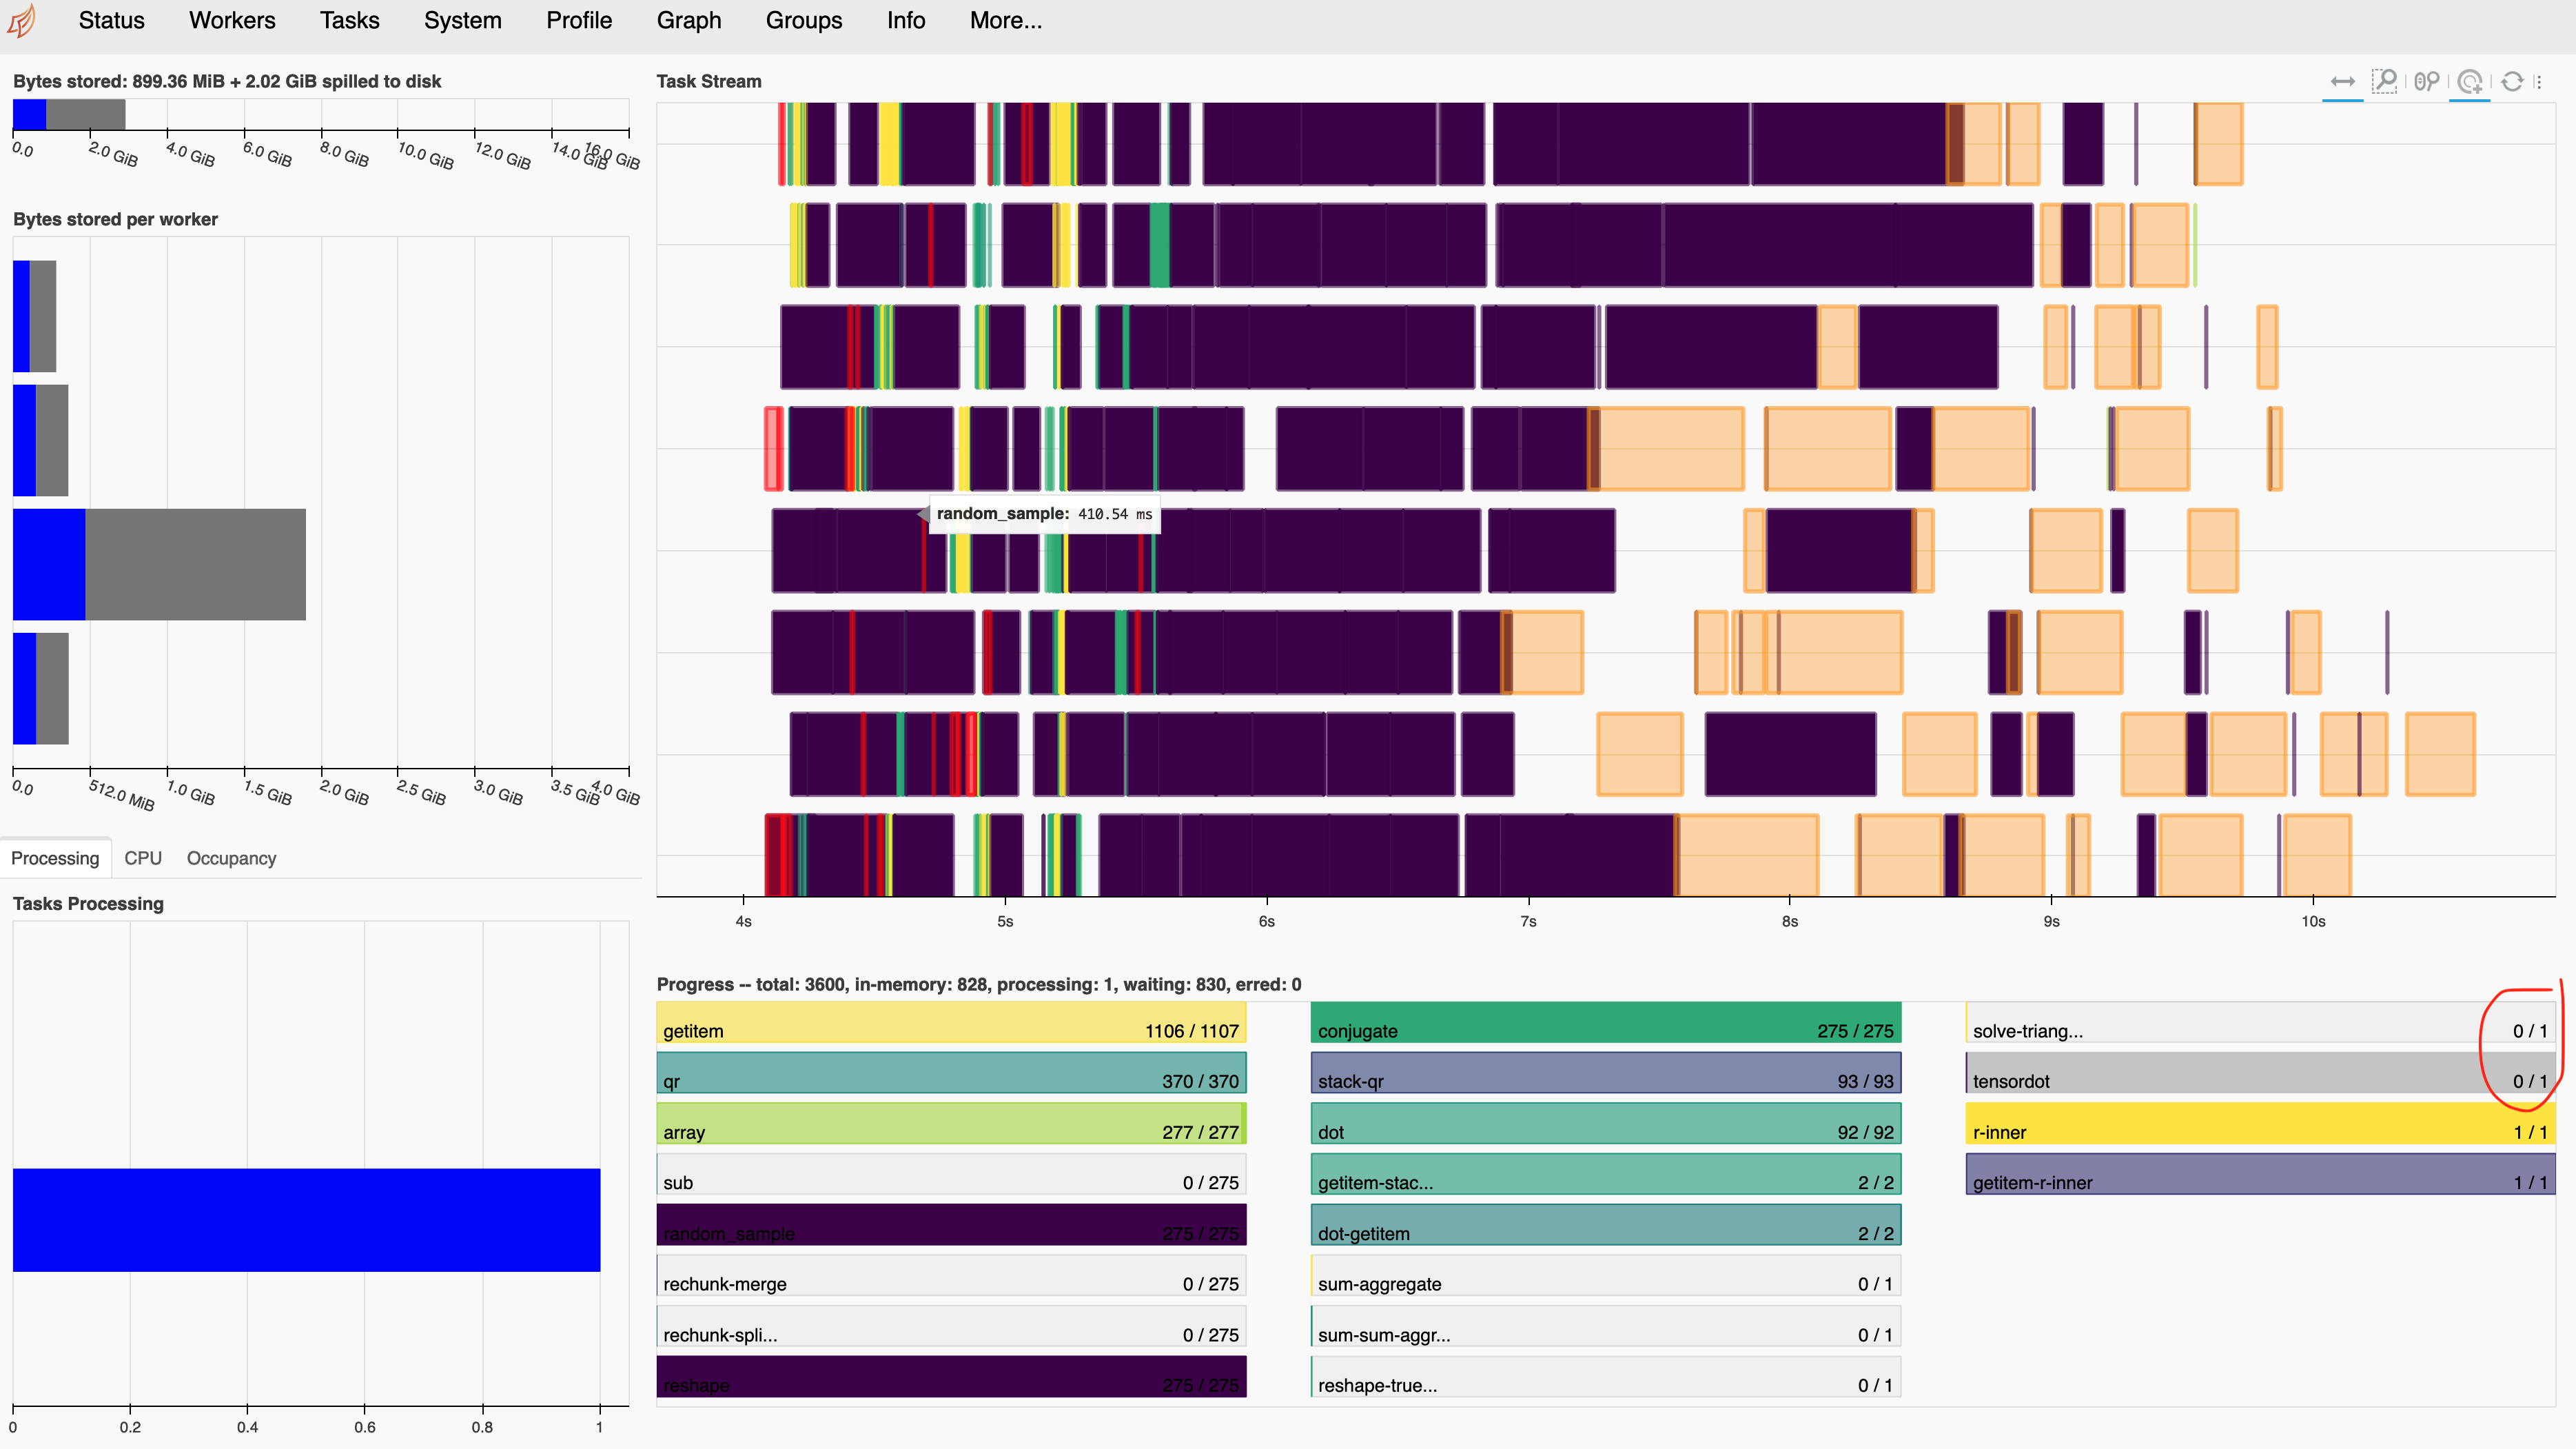

In [5]:
Image("../images/detrend-dask-dashboard-1.png")

What is going wrong?

## Lets look at detrend

Detrend has 3 steps:
1. polyfit
2. polyval
3. subtract

``` python
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg, skipna=False)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit
```

First lets try just `polyfit`

In [6]:
# these are arguments provided to detrend
dim = "ocean_time"
deg = 1

p = da.polyfit(dim=dim, deg=deg, skipna=False)
p

<xarray.Dataset>
Dimensions:               (degree: 2, eta_rho: 489, xi_rho: 655)
Coordinates:
  * degree                (degree) int64 1 0
  * eta_rho               (eta_rho) int64 0 1 2 3 4 5 ... 484 485 486 487 488
  * xi_rho                (xi_rho) int64 0 1 2 3 4 5 ... 649 650 651 652 653 654
Data variables:
    polyfit_coefficients  (degree, eta_rho, xi_rho) float64 dask.array<chunksize=(2, 489, 655), meta=np.ndarray>

Seems OK by which I mean input chunks == output chunks

How about polyval?

In [7]:
fit = xr.polyval(da[dim], p.polyfit_coefficients)
fit

<xarray.DataArray (ocean_time: 2193, eta_rho: 489, xi_rho: 655)>
dask.array<sum-aggregate, shape=(2193, 489, 655), dtype=float64, chunksize=(2193, 489, 655), chunktype=numpy.ndarray>
Coordinates:
  * ocean_time  (ocean_time) int64 0 1 2 3 4 5 ... 2187 2188 2189 2190 2191 2192
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 482 483 484 485 486 487 488
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 648 649 650 651 652 653 654

Aha! Now suddenly we have one giant chunk for the entire array!

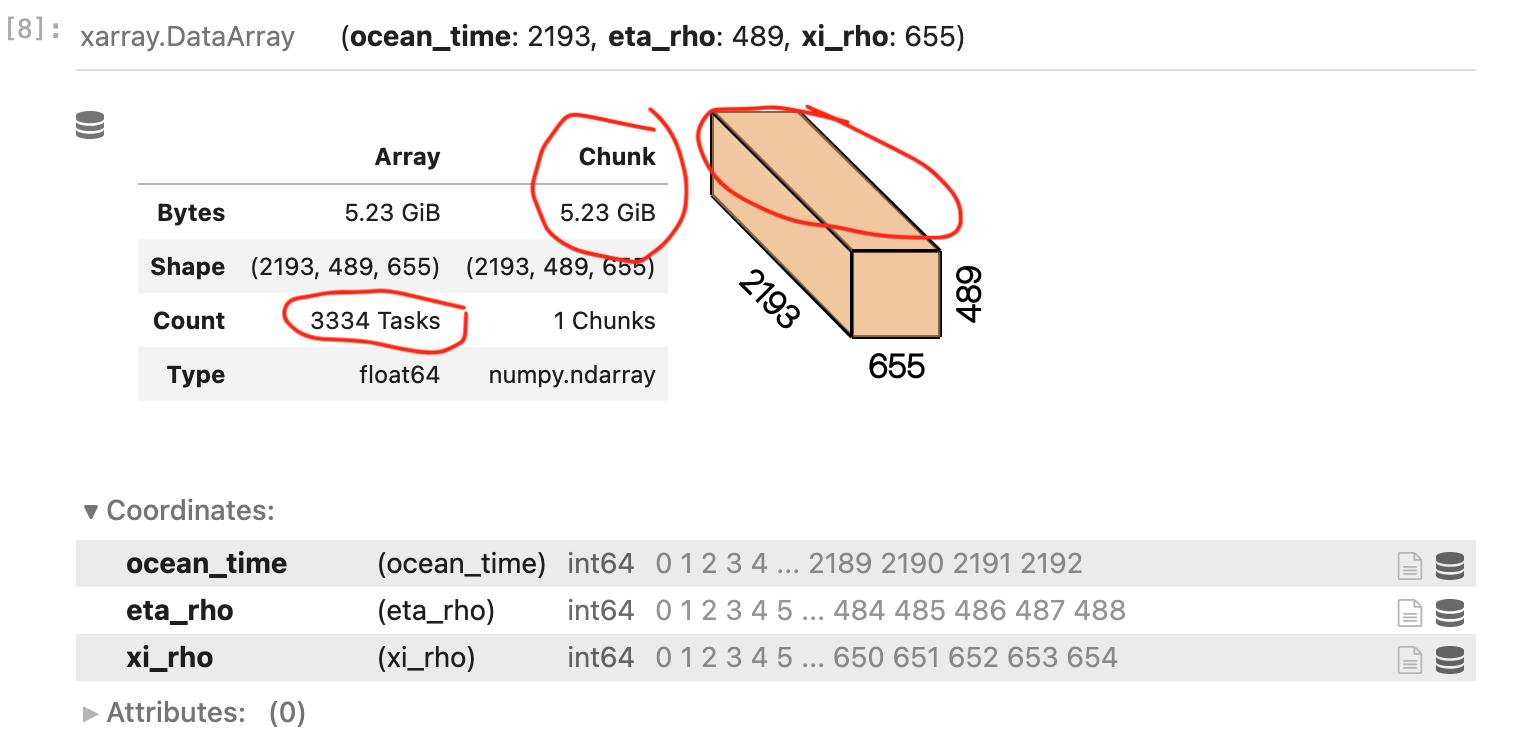

In [8]:
Image("../images/dask-repr.png")

```{tip} The first step to checking your dask workflow is to look for sudden and large changes in number of tasks or chunk size. Pay attention to the dask repr.
```

## Building a better polyval

This required digging in to the code of `xr.polyval`.


In [9]:
# first create a chunked version of the "ocean_time" dimension
chunked_dim = xr.DataArray(
    dask.array.from_array(da[dim].data, chunks=da.chunksizes[dim]), dims=dim, name=dim
)
chunked_dim

<xarray.DataArray 'ocean_time' (ocean_time: 2193)>
dask.array<array, shape=(2193,), dtype=int64, chunksize=(8,), chunktype=numpy.ndarray>
Dimensions without coordinates: ocean_time

In [10]:
def polyval(coord, coeffs, degree_dim="degree"):
    x = coord.data

    deg_coord = coeffs[degree_dim]
    N = int(deg_coord.max()) + 1

    lhs = xr.DataArray(
        np.stack([x ** (N - 1 - i) for i in range(N)], axis=1),
        dims=(coord.name, degree_dim),
        coords={coord.name: coord, degree_dim: np.arange(deg_coord.max() + 1)[::-1]},
    )
    return (lhs * coeffs).sum(degree_dim)


fit = polyval(chunked_dim, p.polyfit_coefficients)
fit

<xarray.DataArray (ocean_time: 2193, eta_rho: 489, xi_rho: 655)>
dask.array<sum-aggregate, shape=(2193, 489, 655), dtype=float64, chunksize=(8, 489, 655), chunktype=numpy.ndarray>
Coordinates:
  * ocean_time  (ocean_time) int64 0 1 2 3 4 5 ... 2187 2188 2189 2190 2191 2192
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 482 483 484 485 486 487 488
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 648 649 650 651 652 653 654

This is a much better `fit` but we still have issues computing  it.

In [ ]:
fit.compute()

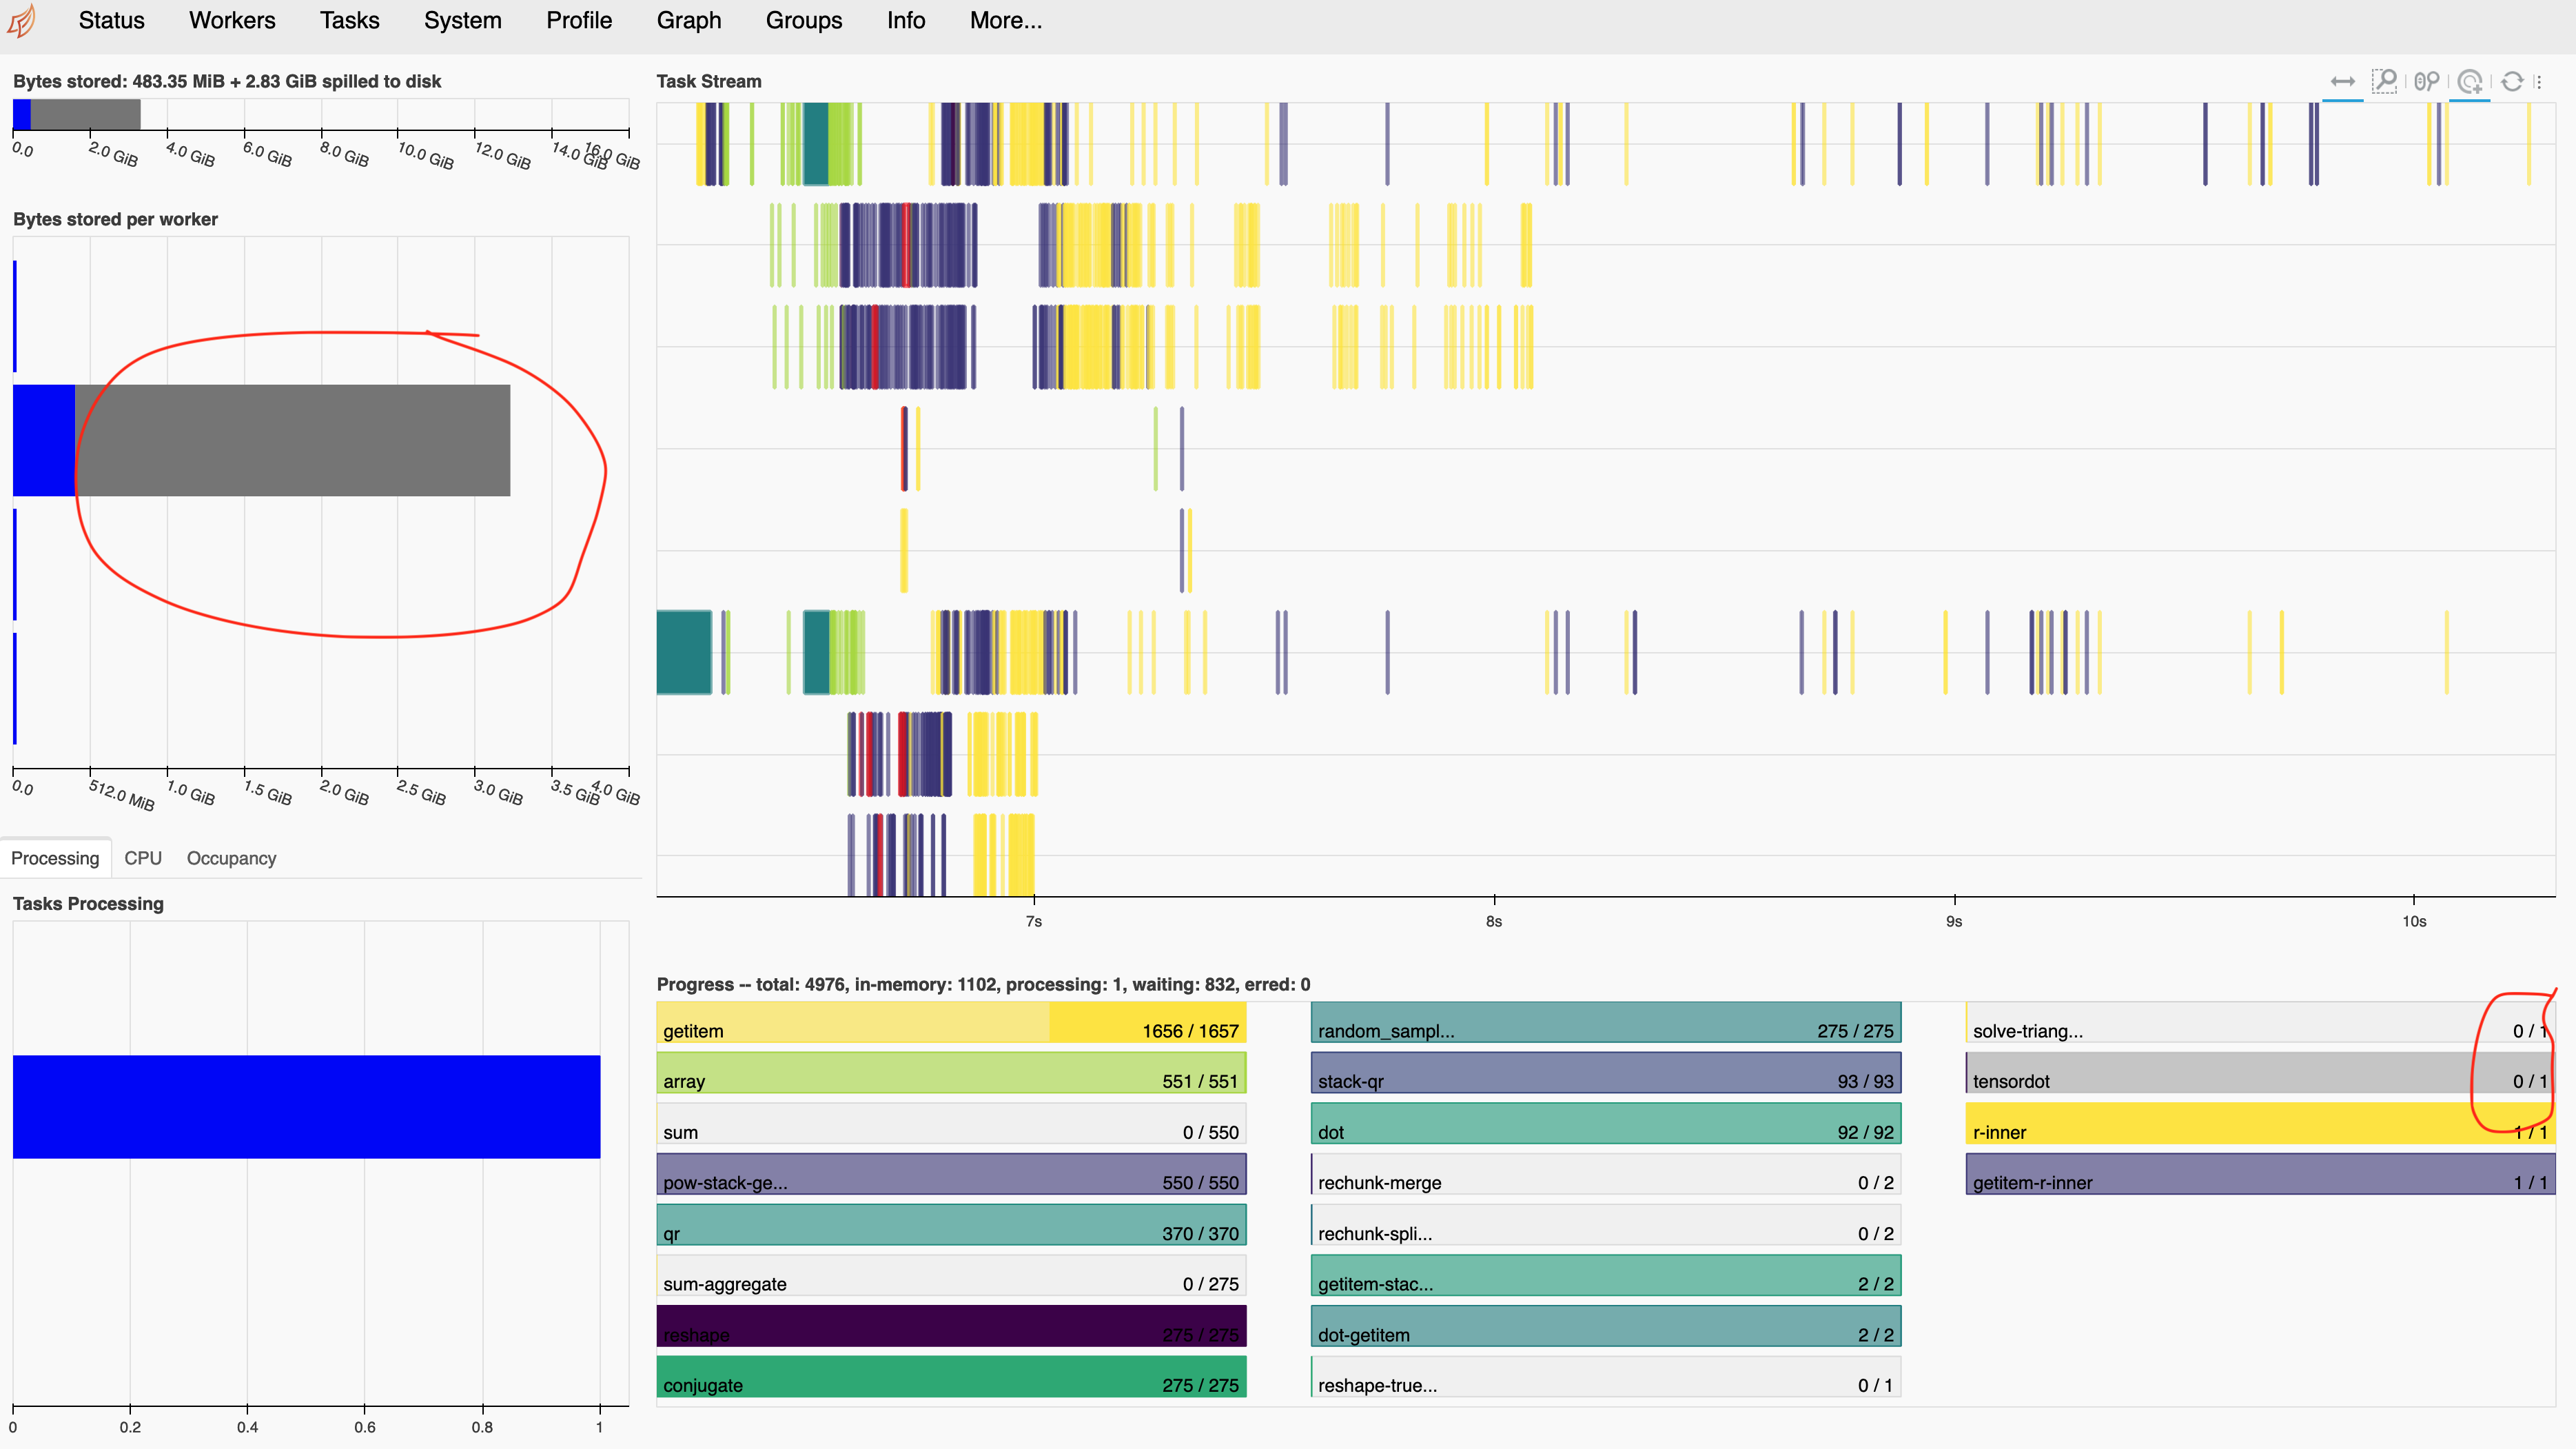

In [11]:
Image("../images/detrend-dask-dashboard-2.png")

Hmm.... that single `tensordot` task still looks problematic. It is probably why we see very skewed memory consumption (mostly one worker). 

Sadly and surprisingly, that wasn't fixed by our new polyval !

## Let's look at polyfit again

But now for a much smaller problem.

```{tip} Visualizing the dask graph can sometimes be instructive but really only works for small problems. Usually we want to see long parallel chains.
```

In [12]:
nt = 24
ny = 489
nx = 655
chunks = (8, -1, -1)

da = xr.DataArray(
    dask.array.random.random((nt, ny, nx), chunks=chunks),
    dims=("ocean_time", "eta_rho", "xi_rho"),
)
da

<xarray.DataArray 'random_sample-10385777f0ac8b370c197c9f50a282cc' (ocean_time: 24, eta_rho: 489, xi_rho: 655)>
dask.array<random_sample, shape=(24, 489, 655), dtype=float64, chunksize=(8, 489, 655), chunktype=numpy.ndarray>
Dimensions without coordinates: ocean_time, eta_rho, xi_rho

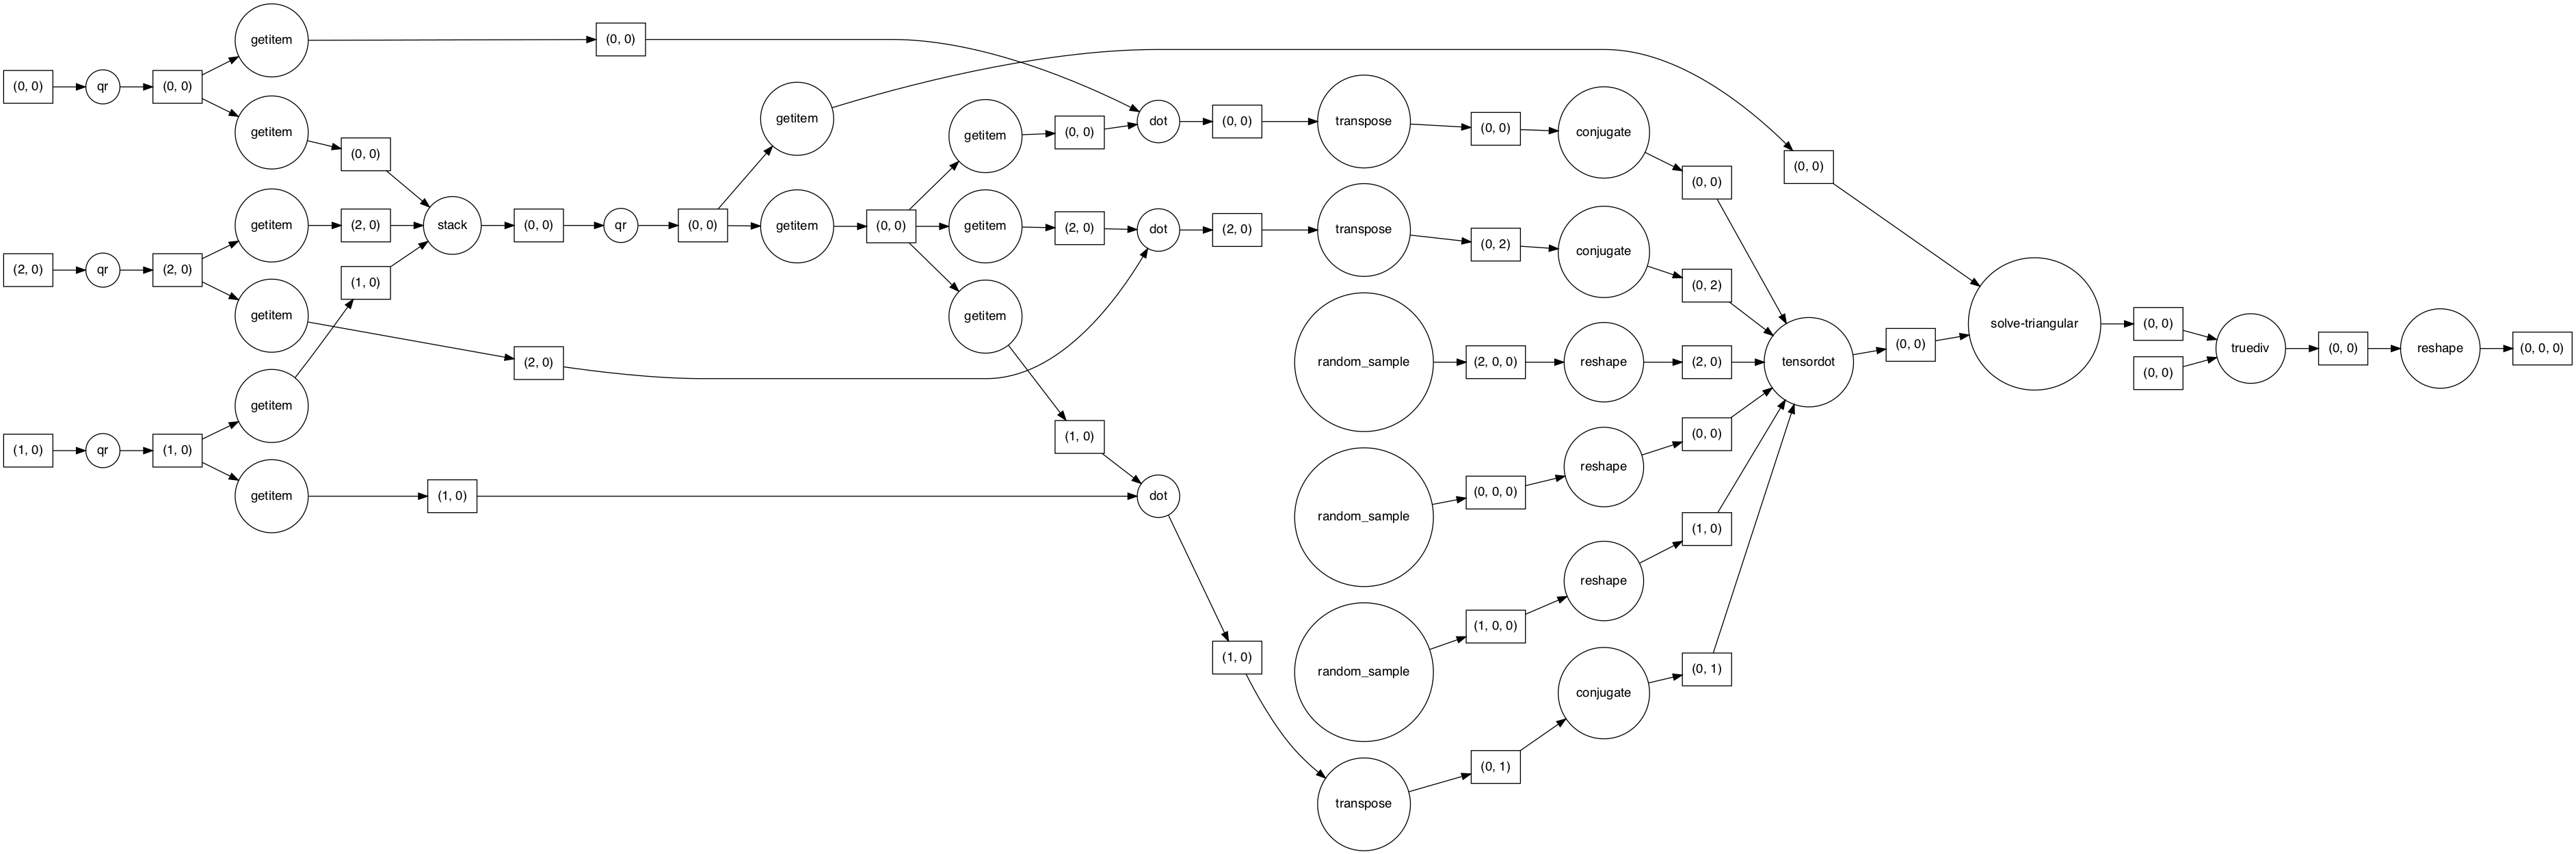

In [15]:
p = da.polyfit(dim="ocean_time", deg=1, skipna=False)
dask.visualize(p, rankdir="LR")

Ouch. we see all the tasks go through a single `tensordot` task. 

This cannot work well. It effectively means that one worker is going to receive all time steps as a single chunk, which implies a lot of memory use and network transfer.

Searching the  dask issue tracker leads to [this issue](https://github.com/dask/dask/issues/6916) so we are stuck for now.

## Workaround?

Potentially this could work if we had larger chunks in time, and smaller chunks in space. This would require an expensive rechunking (basically a full transpose of the chunks) though you could do it with [rechunker](https://github.com/pangeo-data/rechunker) if you were planning to do more operations that would benefit from the rechunking.

Downgrading dask to `dask==2.30.0` shows a much better graph.

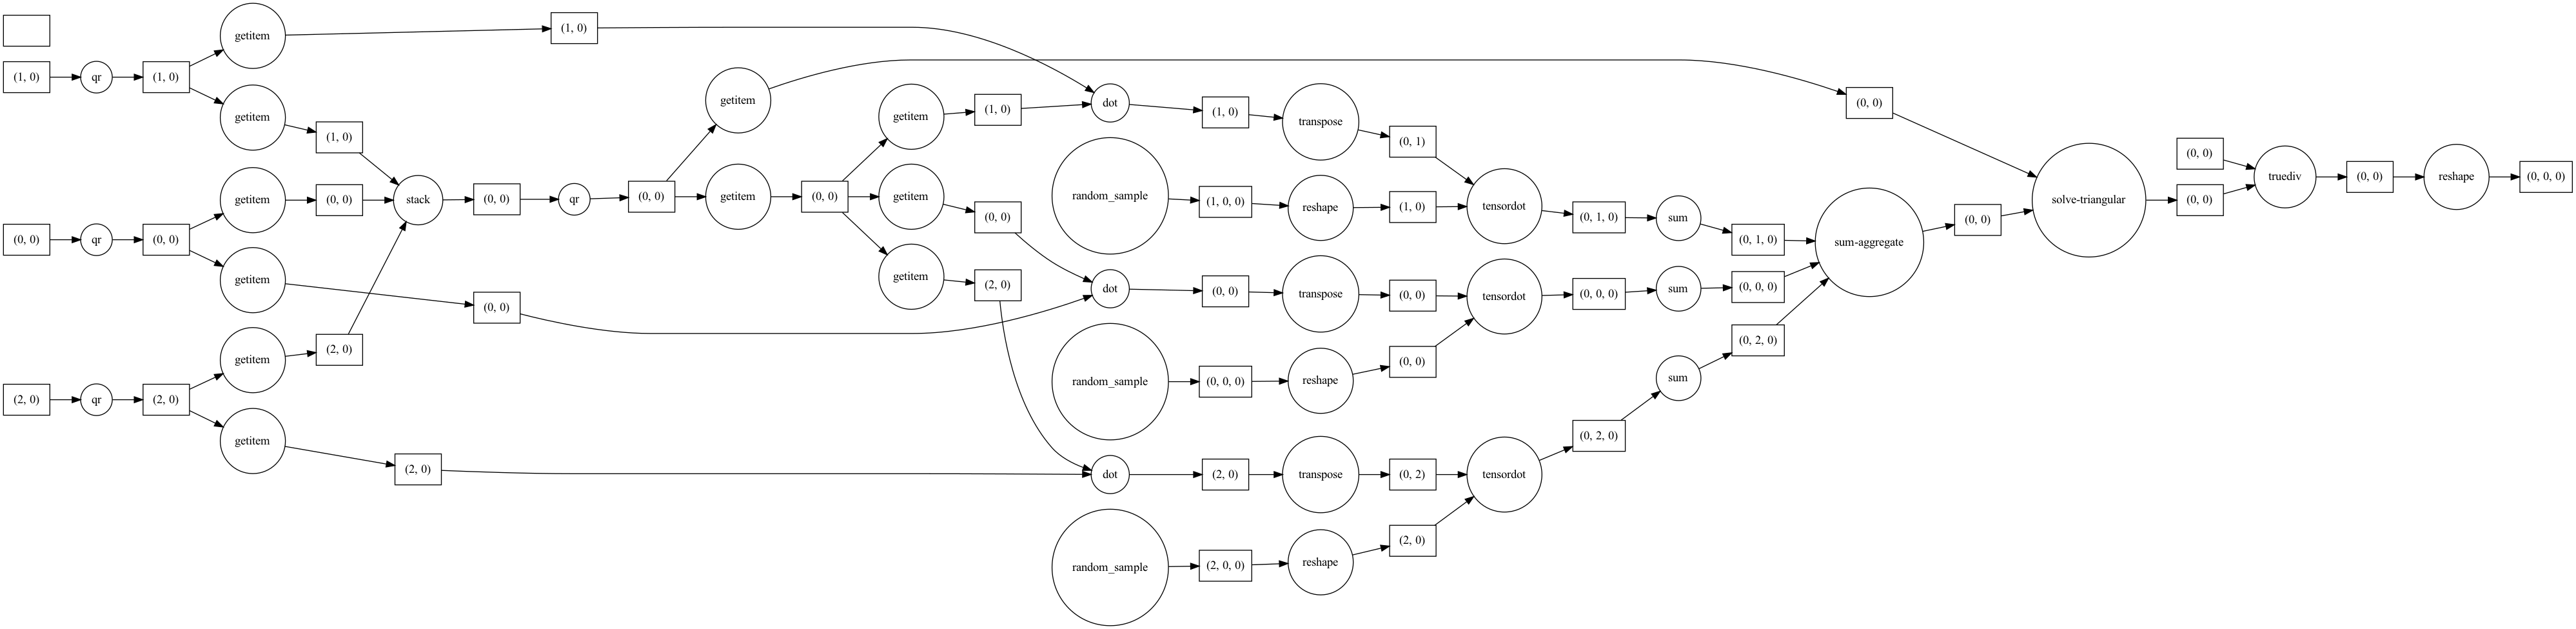

In [2]:
nt = 24
ny = 489
nx = 655
chunks = (8, -1, -1)

da = xr.DataArray(
    dask.array.random.random((nt, ny, nx), chunks=chunks),
    dims=("ocean_time", "eta_rho", "xi_rho"),
)
p = da.polyfit(dim="ocean_time", deg=1, skipna=False)
dask.visualize(p, rankdir="LR")